In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

1. Load and Prepare the Data

In [18]:
with open('aarthy_patients.json', 'r') as file:
    data = json.load(file)

# Extract the relevant JSON content using the expected key
key = "SELECT id, \"content\"::jsonb FROM fhir.patient x"
if key in data:
    cleaned_data = data[key]
else:
    raise KeyError("Expected key not found in JSON data.")
df = pd.DataFrame(cleaned_data)
df.head()

,id,content
0,8b95fdd5-b181-5701-9381-8a13e8618217,"{""id"": ""8b95fdd5-b181-5701-9381-8a13e8618217"",..."
1,c357d0c9-41f5-5d69-9dc4-91f095b2f659,"{""id"": ""c357d0c9-41f5-5d69-9dc4-91f095b2f659"",..."
2,0ec5fdab-eeb5-57ab-af34-99d91b68f9ca,"{""id"": ""0ec5fdab-eeb5-57ab-af34-99d91b68f9ca"",..."
3,fcb57ef3-b4de-4fe4-ac55-f6f64e634af0,"{""id"": ""fcb57ef3-b4de-4fe4-ac55-f6f64e634af0"",..."
4,4c435cf9-ad33-5957-9614-cd4c19cf5020,"{""id"": ""4c435cf9-ad33-5957-9614-cd4c19cf5020"",..."


In [19]:
# Convert the 'content' field from JSON string to dictionary
df["content"] = df["content"].apply(json.loads)

# Flatten the JSON content into columns
df_expanded = pd.json_normalize(df["content"])
df_expanded["id"] = df["id"]

# Convert list-type columns (if any) to strings for consistency
df_expanded["address"] = df_expanded["address"].apply(lambda x: str(x) if isinstance(x, list) else x)
df_expanded["contact"] = df_expanded["contact"].apply(lambda x: str(x) if isinstance(x, list) else x)
df_expanded["name"] = df_expanded["name"].apply(lambda x: str(x) if isinstance(x, list) else x)

# Replace any missing values in key columns with empty strings
df_expanded[["birthDate", "address", "contact", "name"]] = df_expanded[["birthDate", "address", "contact", "name"]].fillna("")

# Convert the 'meta.lastUpdated' field to datetime (timezone aware if indicated by the string)
df_expanded["meta.lastUpdated"] = pd.to_datetime(df_expanded["meta.lastUpdated"])
# Create a new column with just the date part for daily grouping
df_expanded["date"] = df_expanded["meta.lastUpdated"].dt.date
df_expanded.head()

,id,name,photo,active,gender,address,contact,telecom,birthDate,identifier,resourceType,meta.versionId,meta.lastUpdated,date
0,8b95fdd5-b181-5701-9381-8a13e8618217,"[{'text': 'VELLAIYAMMAL', 'prefix': ['mrs']}]","[{'url': 'data:image/jpeg;base64,/9j/4AAQSkZJR...",True,female,"[{'text': 'LALAPETTAI KARUR', 'postalCode': ''}]","[{'relationship': [{'text': 'KARUPPAN', 'codin...","[{'value': '8610931848', 'system': 'phone'}]",1967-05-20,"[{'value': '240500596', 'system': 'https://med...",Patient,9f81d32f-e2c8-4a7b-bf84-aa43a188e60f,2025-02-10 03:01:50.134000+00:00,2025-02-10
1,c357d0c9-41f5-5d69-9dc4-91f095b2f659,"[{'text': 'PAPPAYEE', 'prefix': ['mrs']}]","[{'url': 'data:image/jpeg;base64,/9j/4AAQSkZJR...",True,female,"[{'text': 'VENNILAI VENNILAI KARUR', 'postalC...","[{'relationship': [{'text': 'PALANISAMY', 'cod...","[{'value': '9626544881', 'system': 'phone'}]",1964-04-22,"[{'value': 'AHA033842', 'system': 'https://med...",Patient,48c2bad4-33fc-405b-af37-5a2cb03cf8c8,2025-02-10 03:08:35.501000+00:00,2025-02-10
2,0ec5fdab-eeb5-57ab-af34-99d91b68f9ca,"[{'text': 'SELVA KUMAR', 'prefix': ['mr']}]","[{'url': 'data:image/jpeg;base64,/9j/4AAQSkZJR...",True,male,"[{'text': 'K. PARAMATHI KARUR', 'postalCode': ...","[{'relationship': [{'text': 'MUTHUSAMY', 'codi...","[{'value': '9952645957', 'system': 'phone'}]",1989-08-23,"[{'value': 'AHA051239', 'system': 'https://med...",Patient,f817f882-e038-4c4e-ae0f-9fb20ec72209,2025-02-10 03:11:46.083000+00:00,2025-02-10
3,fcb57ef3-b4de-4fe4-ac55-f6f64e634af0,"[{'text': 'MYMUN BEEBI', 'prefix': ['mrs']}]","[{'url': 'data:image/jpeg;base64,/9j/4AAQSkZJR...",True,female,"[{'text': 'KARUR', 'postalCode': ''}]","[{'relationship': [{'text': 'KALIL', 'coding':...","[{'value': '8428131217', 'system': 'phone'}]",1963-02-09,"[{'value': 'AEHMB191314', 'system': 'https://m...",Patient,1bbc667d-f7d3-487d-897f-6e3aad2945da,2025-02-10 03:41:07.293000+00:00,2025-02-10
4,4c435cf9-ad33-5957-9614-cd4c19cf5020,"[{'text': 'SELVAM', 'prefix': ['mr']}]",[],True,male,"[{'text': 'GANDHIGRAMAM', 'postalCode': ''}]","[{'relationship': [{'text': 'ANANDHAM', 'codin...","[{'value': '9965347524', 'system': 'phone'}]",1971-02-09,"[{'value': 'AHA168248', 'system': 'https://med...",Patient,a695f6a8-18ef-43d9-ad9b-99de79e32ff0,2025-02-10 03:56:43.700000+00:00,2025-02-10


In [20]:
# ----------------------------
# 2. Filter Data for the Analysis Period
# ----------------------------
# We are interested only in records from December 1, 2024 onward.
start_date = pd.to_datetime("2024-12-01").date()
df_expanded = df_expanded[df_expanded["date"] >= start_date]

# Method 1: Graphical Analysis

In [21]:
# Create a patient identifier for grouping
df_expanded["patient_id"] = df_expanded["name"] + "_" + df_expanded["birthDate"]

# Daily record count (all records per day)
daily_counts = df_expanded.groupby("date").size().reset_index(name="record_count")

# Daily count of unique patients added that day
daily_unique = df_expanded.groupby("date")["patient_id"].nunique().reset_index(name="unique_patients")

# Cumulative unique patients over time
daily_unique["cumulative_unique_patients"] = daily_unique["unique_patients"].cumsum()

# Define cutoff date
cutoff_date = pd.to_datetime("2024-12-10").date()

1) DAILY RECORD COUNT FIGURE

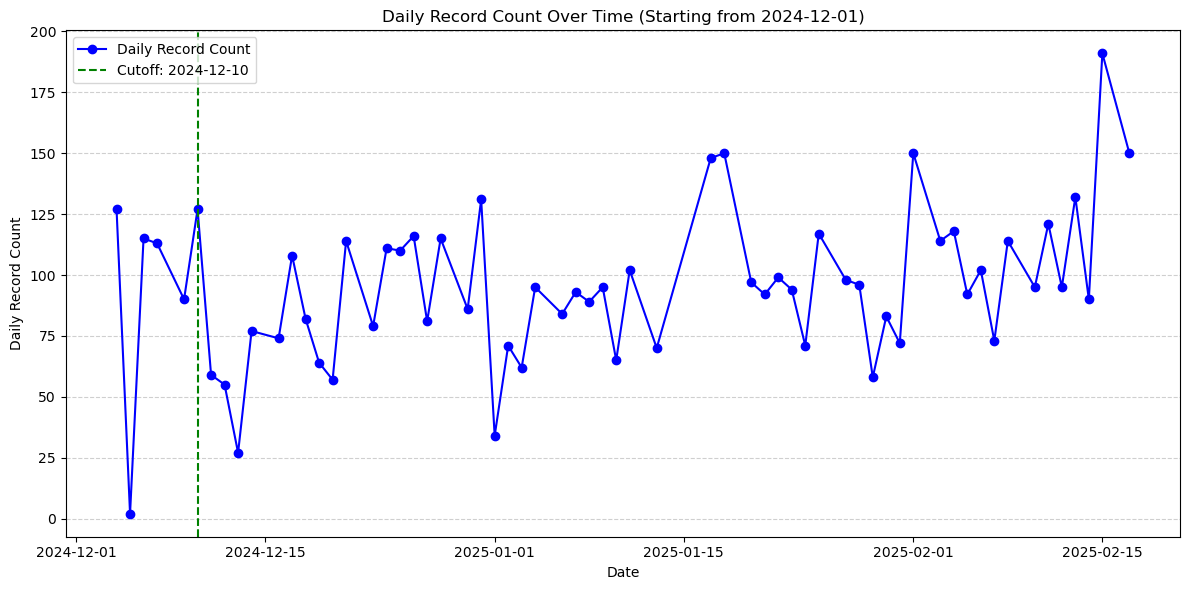

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(daily_counts["date"], daily_counts["record_count"],
         color="blue", marker="o", label="Daily Record Count")

# Add a vertical line for the cutoff date
plt.axvline(cutoff_date, color='green', linestyle='--', label=f"Cutoff: {cutoff_date}")

plt.title("Daily Record Count Over Time (Starting from 2024-12-01)")
plt.xlabel("Date")
plt.ylabel("Daily Record Count")
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.6)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

2) CUMULATIVE UNIQUE PATIENTS FIGURE


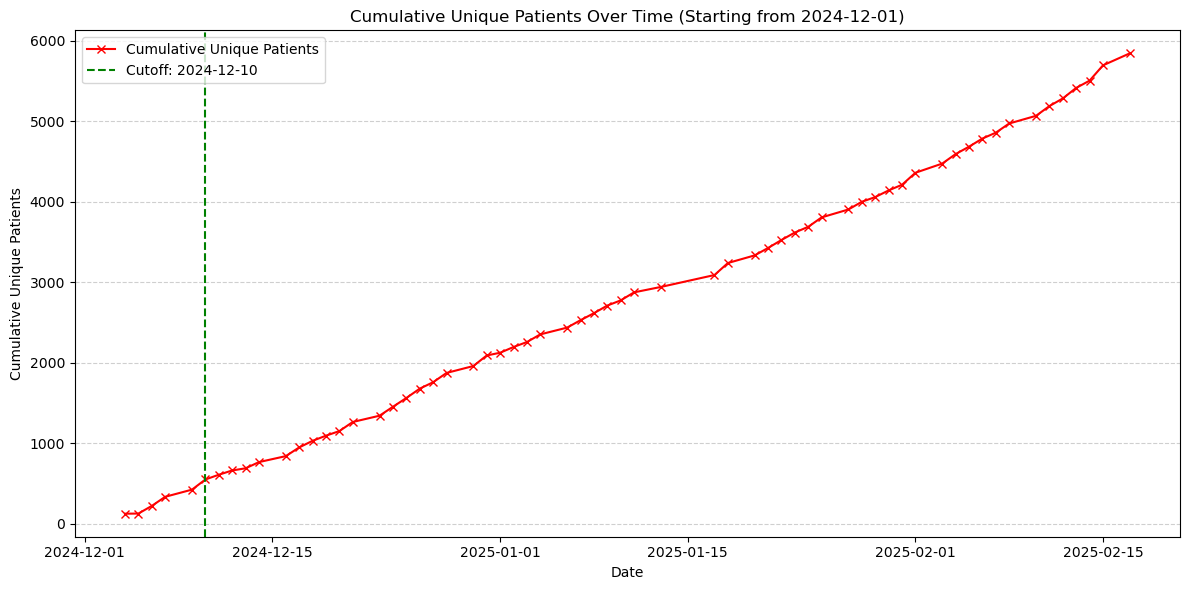

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(daily_unique["date"], daily_unique["cumulative_unique_patients"],
         color="red", marker="x", label="Cumulative Unique Patients")

# Add a vertical line for the cutoff date
plt.axvline(cutoff_date, color='green', linestyle='--', label=f"Cutoff: {cutoff_date}")

plt.title("Cumulative Unique Patients Over Time (Starting from 2024-12-01)")
plt.xlabel("Date")
plt.ylabel("Cumulative Unique Patients")
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.6)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

Since the graph values are progressively increasing, we can assume that new records are added rather than updating existing ones

In [8]:
# ----------------------------
# Label Each Record as New or Update
# ----------------------------

# Create a unique patient identifier (adjust if needed)
df_expanded["patient_id"] = df_expanded["name"] + "_" + df_expanded["birthDate"]

# Sort by patient_id and date so that earlier records come first
df_expanded.sort_values(by=["patient_id", "date"], inplace=True)

# For each patient, the first occurrence is "New", later ones are "Update"
df_expanded["is_new"] = df_expanded.groupby("patient_id").cumcount() == 0
df_expanded["record_type"] = df_expanded["is_new"].apply(lambda x: "New" if x else "Update")


In [9]:
# ----------------------------
# Compute Daily Counts and Proportions
# ----------------------------

# Count records per day for each record type
daily_record_types = df_expanded.groupby(["date", "record_type"]).size().reset_index(name="count")

# Pivot the data so that each date has columns "New" and "Update"
daily_pivot = daily_record_types.pivot(index="date", columns="record_type", values="count").fillna(0)

# Calculate the total records per day and the proportions
daily_pivot["total"] = daily_pivot.sum(axis=1)
daily_pivot["new_prop"] = daily_pivot["New"] / daily_pivot["total"]
daily_pivot["update_prop"] = daily_pivot["Update"] / daily_pivot["total"]

Stacked Bar Chart of Daily Counts


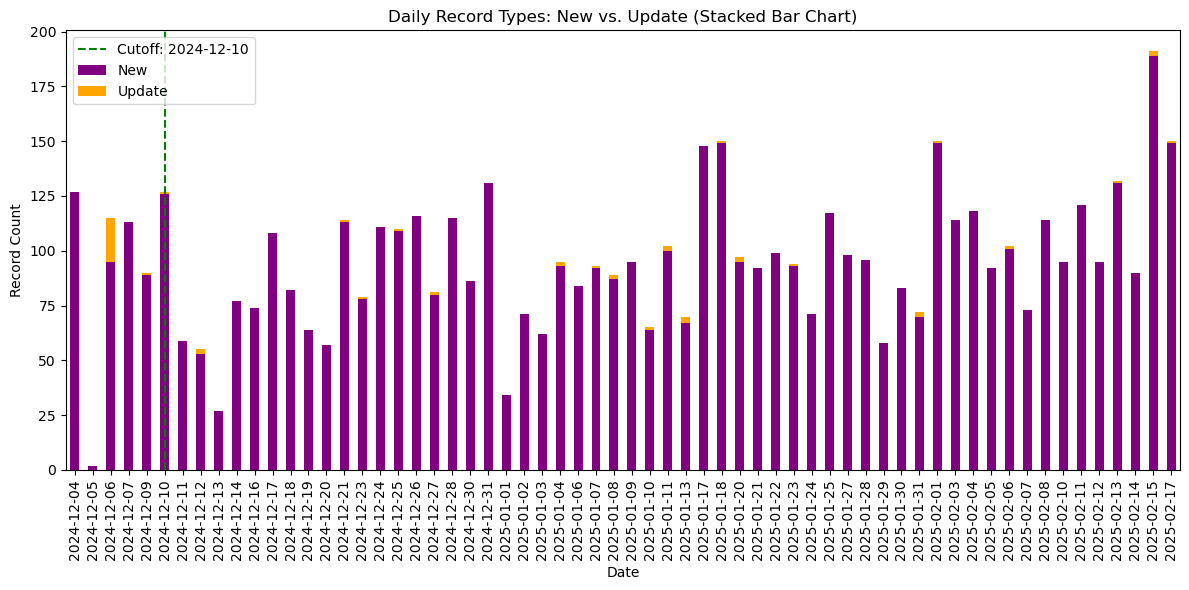

In [ ]:
# Define the cutoff date (December 10, 2024)
cutoff_date = pd.to_datetime("2024-12-10").date()

plt.figure(figsize=(12, 6))
# Plot a stacked bar chart for New and Update counts
daily_pivot[["New", "Update"]].plot(kind="bar", stacked=True, color=["purple", "orange"], ax=plt.gca())
plt.axvline(x=list(daily_pivot.index).index(cutoff_date), color='green', linestyle='--', 
            label=f"Cutoff: {cutoff_date}")  # Note: using index position for the vertical line
plt.title("Daily Record Types: New vs. Update (Stacked Bar Chart)")
plt.xlabel("Date")
plt.ylabel("Record Count")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

The proportion of new records being added to total number of records is much higher than the proportion of records being updated

# Method 2: Chi Square Analysis

In [ ]:
# ----------------------------
# 4. Split Data into Pre-Cutoff and Post-Cutoff Periods for Chi square analysis
# ----------------------------
# Define the cutoff date: December 10, 2024.
cutoff_date = pd.to_datetime("2024-12-10").date()

# Split the dataset:
pre_cutoff_df = df_expanded[df_expanded["date"] < cutoff_date]
post_cutoff_df = df_expanded[df_expanded["date"] >= cutoff_date]


In [24]:
# Count the records in each category for pre-cutoff period
pre_counts = pre_cutoff_df["record_type"].value_counts()
# Count the records in each category for post-cutoff period
post_counts = post_cutoff_df["record_type"].value_counts()

print("Pre-cutoff Record Counts:")
print(pre_counts)
print("\nPost-cutoff Record Counts:")
print(post_counts)

Pre-cutoff Record Counts:
record_type
New       426
Update     21
Name: count, dtype: int64

Post-cutoff Record Counts:
record_type
New       5415
Update      30
Name: count, dtype: int64


In [16]:
# Build a 2x2 contingency table:
# Rows: [Pre, Post]
# Columns: [New, Update]
contingency = np.array([
    [pre_counts.get("New", 0), pre_counts.get("Update", 0)],
    [post_counts.get("New", 0), post_counts.get("Update", 0)]
])
print("\nContingency Table (rows: Pre vs. Post, columns: New, Update):")
print(contingency)
# Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency)
print("\nChi-square Test Results:")
print(f"Chi2 Statistic: {chi2}")
print(f"Degrees of Freedom: {dof}")
print(f"p-value: {p_value}")
print("Expected Frequencies:")
print(expected)


Contingency Table (rows: Pre vs. Post, columns: New, Update):
[[ 426   21]
 [5415   30]]

Chi-square Test Results:
Chi2 Statistic: 78.02874104434642
Degrees of Freedom: 1
p-value: 1.0155214004321016e-18
Expected Frequencies:
[[4.43130855e+02 3.86914460e+00]
 [5.39786914e+03 4.71308554e+01]]


The chi-square test indicates that the proportion of "New" versus "Update" records is significantly different between the pre‑cutoff and post‑cutoff periods. Here’s what you can infer:

Pre‑cutoff (Before December 10, 2024):

About 95% of records were labeled as "New" (426 out of 447 total records) and roughly 5% as "Update."


Post‑cutoff (On/After December 10, 2024):

Over 99% of records are "New" (5415 out of 5445 total records), with less than 1% being "Update."


# Statistical Significance:

The chi-square statistic (≈78) with 1 degree of freedom yields a p‑value on the order of 10⁻¹⁸, which is extremely small. This means the difference in proportions is very unlikely to be due to random chance.


# Interpretation
Significant Shift in Record Types:
The dramatic drop in the proportion of updates post‑cutoff (from about 5% to less than 1%) suggests that after December 10, 2024, the system is creating new records much more frequently relative to updating existing ones.

# Testing the Hypothesis:
If you expected that a hospital naturally receives many new patients, one might still see a high number of new records overall. However, the significant decrease in the update rate post‑cutoff (when compared to the pre‑cutoff period) supports the hypothesis that—beyond the normal influx of new patients—the system might be adding new records even when it should be updating existing ones.



In summary, the statistical test confirms a significant change in the way records are being handled after December 10, 2024, lending strong support to your hypothesis that new records are being created rather than updating existing records.

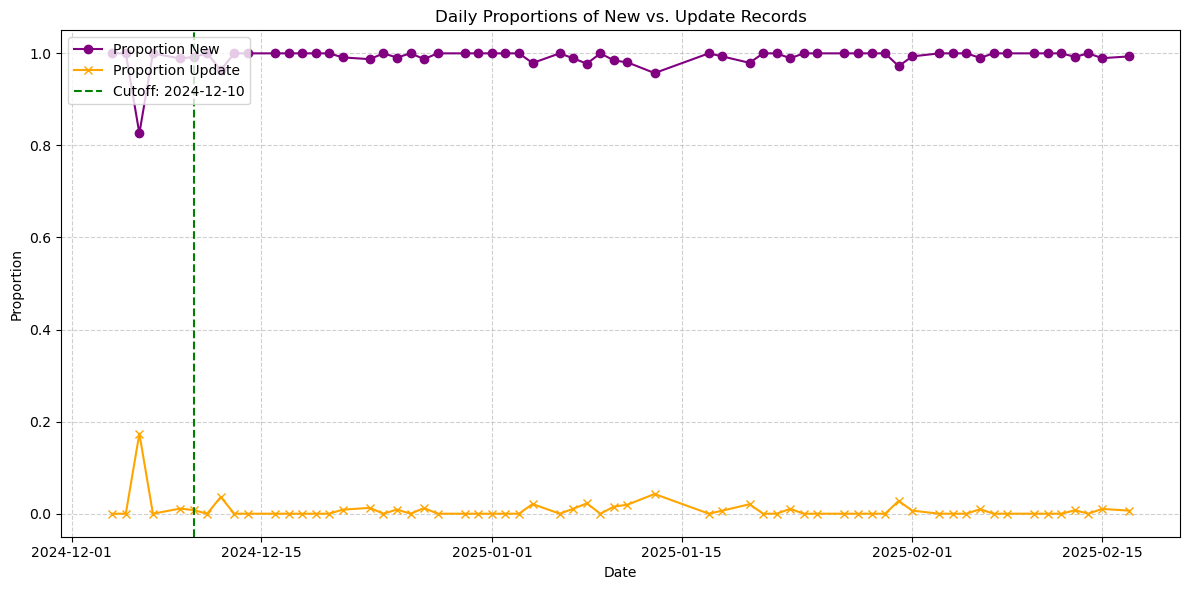

In [ ]:
# ----------------------------
# 5. Visualize Daily Proportions
# ----------------------------

# Count records per day for each record type
daily_record_types = df_expanded.groupby(["date", "record_type"]).size().reset_index(name="count")
# Pivot to have one row per date with columns for New and Update
daily_pivot = daily_record_types.pivot(index="date", columns="record_type", values="count").fillna(0)

# Calculate total records per day and the proportion of each type
daily_pivot["total"] = daily_pivot.sum(axis=1)
daily_pivot["new_prop"] = daily_pivot["New"] / daily_pivot["total"]
daily_pivot["update_prop"] = daily_pivot["Update"] / daily_pivot["total"]

plt.figure(figsize=(12, 6))
plt.plot(daily_pivot.index, daily_pivot["new_prop"], marker="o", label="Proportion New", color="purple")
plt.plot(daily_pivot.index, daily_pivot["update_prop"], marker="x", label="Proportion Update", color="orange")
plt.axvline(cutoff_date, color='green', linestyle='--', label=f"Cutoff: {cutoff_date}")
plt.title("Daily Proportions of New vs. Update Records")
plt.xlabel("Date")
plt.ylabel("Proportion")
plt.legend(loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()